In [1]:
import os
from pathlib import Path
import json
import matplotlib.pyplot as plt
import pandas as pd
import shutil
import collections
import cv2

In [2]:
DATA = Path('./data/final/f_circle/ds/')

## DATASET

In [3]:
dataset = {
    'train': DATA / 'train',
    'val': DATA / 'val',
    'test': DATA / 'test'
}

## CLEAN 

In [4]:
for n, p in dataset.items():
    f0 = p / '.ipynb_checkpoints'
    f1 = p / 'bbox' / '.ipynb_checkpoints'
    f2 = p / 'image' / '.ipynb_checkpoints'
    fs = [f0, f1,f2]
    for f in fs:
        if f.exists():
            shutil.rmtree(str(f), ignore_errors=False, onerror=None)
            print('Removed', f)

Removed data/final/f_circle/ds/train/image/.ipynb_checkpoints
Removed data/final/f_circle/ds/val/image/.ipynb_checkpoints
Removed data/final/f_circle/ds/test/image/.ipynb_checkpoints


## READ UNIVERSAL LABEL

In [5]:
global_label = []

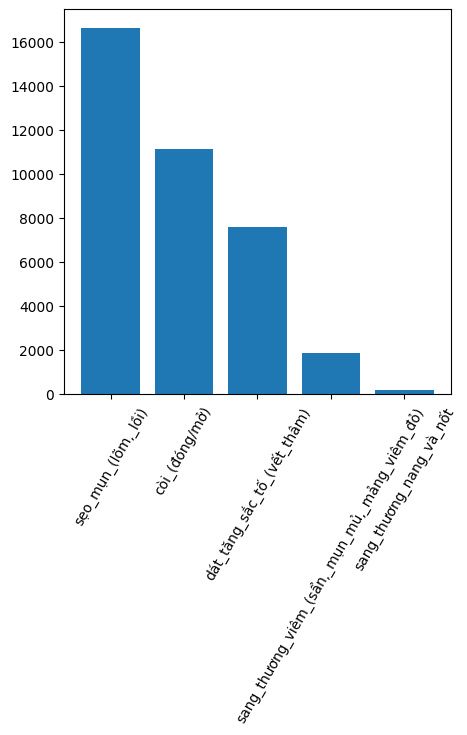

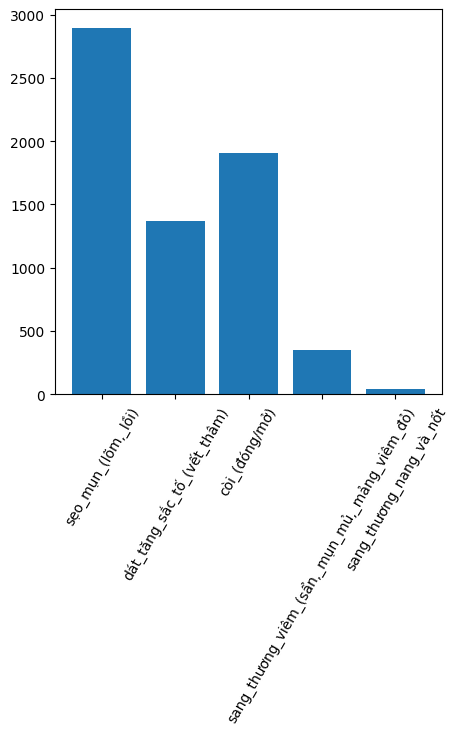

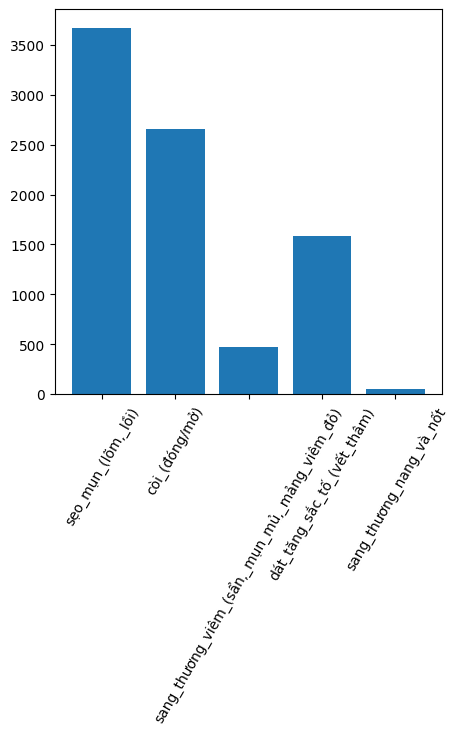

In [6]:
for ds, f in dataset.items():
    bbox = f / 'bbox'
    img = f / 'image'
    
    acne_ds = []
    for b in bbox.iterdir():
        if '.ipynb_checkpoints' in b.name:
            shutil.rmtree(str(b), ignore_errors=False, onerror=None)
            continue
        df = pd.read_csv(b, index_col=0)
        acnes = df['label'].tolist()
        acne_ds.extend(acnes)
        global_label.extend(acnes)
    
    stat_ds = collections.Counter(acne_ds)
    plt.figure(figsize=(5,5))
    x, y = list(stat_ds.keys()), list(stat_ds.values())
    plt.bar(x,y)
    plt.xticks(rotation=60)
    plt.show()

In [7]:
stats = collections.Counter(global_label)

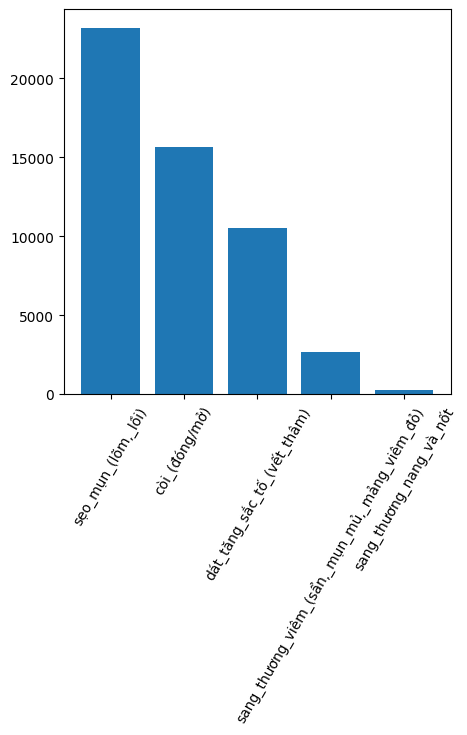

In [8]:
plt.figure(figsize=(5,5))
x, y = list(stats.keys()), list(stats.values())
plt.bar(x,y)
plt.xticks(rotation=60)
plt.show()

In [9]:
global_label = list(set(global_label))

In [10]:
global_label = {k:v for k, v in enumerate(global_label)}
global_label

{0: 'sẹo_mụn_(lõm,_lồi)',
 1: 'sang_thương_nang_và_nốt',
 2: 'dát_tăng_sắc_tố_(vết_thâm)',
 3: 'còi_(đóng/mở)',
 4: 'sang_thương_viêm_(sẩn,_mụn_mủ,_mảng_viêm_đỏ)'}

In [11]:
global_label_inv = {v:k for k, v in global_label.items()}
global_label_inv

{'sẹo_mụn_(lõm,_lồi)': 0,
 'sang_thương_nang_và_nốt': 1,
 'dát_tăng_sắc_tố_(vết_thâm)': 2,
 'còi_(đóng/mở)': 3,
 'sang_thương_viêm_(sẩn,_mụn_mủ,_mảng_viêm_đỏ)': 4}

## GENERATE COCO

In [12]:
def generate_dataset_coco(path):
    def parse_str2dict(t):
        text = t.strip()
        text = text.replace('{','').replace('}','').replace('\'','').replace('\"','')
        items = text.split(',')
        keys, values = [], []
        for item in items:
            k,v = item.split(':')
            keys.append(k.strip())
            values.append(int(v.strip()))
        return dict(zip(keys, values))
    
    bbox_f = path / 'bbox'
    img_f = path / 'image'
    
    coco = {
        'info': {},
        'licenses': [],
        'categories': [],
        'images': [],
        'annotations': []
    }
    
    # Info
    #
    # License
    #
    # Category
    categories = [{"id": _id, "name": name} for _id, name in global_label.items()]
    coco['categories'] = categories
    # Image
    image_infos = []
    all_images = [i for i in img_f.iterdir() if '.jpeg' in str(i)]
    for idx, f in enumerate(all_images):
        img_info = {}
        n = f.name
        p = str(f)
        img = cv2.imread(p)
        h,w = img.shape[:2]
        img_info['id'] = idx
        img_info['width'] = w
        img_info['height'] = h
        img_info['file_name'] = n
        image_infos.append(img_info)
    coco['images'] = image_infos
    # Annotation
    anno_id = 0
    anno_infos = []
    for img_info in coco['images']:
        img_id = img_info['id']
        bbox_n = img_info['file_name'].split('.')[0] + '.csv'
        bbox_content = pd.read_csv(str(bbox_f / bbox_n), index_col=0)
        for an_idx, row in bbox_content.iterrows():
            category_id = global_label_inv[row['label']]
            b_c = parse_str2dict(row['objects'])
            bbox = [b_c['left'], b_c['top'], b_c['width'], b_c['height']]
            x0, y0, x1, y1 = b_c['left'], b_c['top'], b_c['left'] + b_c['width'], b_c['top'] + b_c['height']
            anno_info = {
                'id': anno_id,
                'image_id': int(img_id),
                'category_id': int(category_id),
                'segmentation': [[x0, y0, x0, y1, x1, y1,x1, y0]],
                'area': b_c['width'] * b_c['height'],
                'bbox': bbox,
                'iscrowd': 0,
            }
            anno_infos.append(anno_info)
            anno_id += 1
    coco['annotations'] = anno_infos
    return coco

In [13]:
coco_dataset = {}

In [14]:
for name, path in dataset.items():
    coco_dataset[name] = generate_dataset_coco(path)

In [15]:
for name, path in dataset.items():
    json.dump(coco_dataset[name], open(path / 'coco_instances.json', 'w'))